In [1]:
from finlab.data import Data

# 可以從 data 中讀取資料
data = Data()

In [4]:
# 從 close, high, low 取從最新的一筆資料往前算，2000筆資料
close = data.get('收盤價', 2000)
high = data.get('最高價', 2000)
low = data.get('最低價', 2000)

Data: **ERROR: cannot find 股價 in database


In [2]:
import talib
import pandas as pd

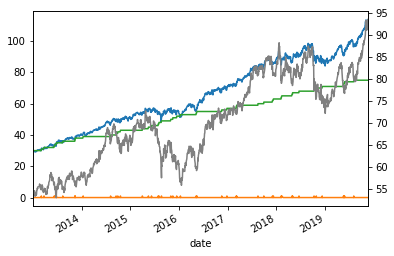

In [3]:
import talib
import pandas as pd

# 利用 talib 來計算 0050 這檔股票的指標
kd = talib.STOCH(high['0050'].ffill().values, 
                 low['0050'].ffill().values, 
                 close['0050'].ffill().values,
                 fastk_period=9, slowk_period=3
                 , slowd_period=3, slowk_matype=1, slowd_matype=1)

# 將 kd 值 分別轉換成 k、d 兩條 series
k = pd.Series(kd[0], index=close['0050'].index)
d = pd.Series(kd[1], index=close['0050'].index)

# & 代表 「且」 的意思，這邊的條件就是
# k.shift(1) 可以想成「昨天」的意思，同理 k.shift(2) 就是前天
# 當（今天的 k > d ）且 （昨天的 k < d） 且 （今天的 k < 30） 時，買入

buy = (k > d) & (k.shift(1) < d.shift(1)) & (k < 30)

# 起始資金為 30 萬，這段可以參考「老師的話」當中的範例
arr = [30]
for v, p in zip(buy[1:], close['0050'].shift(-2)/close['0050'].shift(-1)):
    arr.append(arr[-1]*p + v)

# 畫圖
%matplotlib inline

# 先畫出 0050 收盤價
close['0050'].plot(secondary_y=True, color='gray')

# 畫出投資獲利
pd.Series(arr, index=close['0050'].index).plot()

# 畫出買入的時間點
buy.astype(int).plot()

# 畫出一樣的金額假如放在銀行，的資產變化
(buy.astype(int).cumsum() + 30).plot()

In [5]:
import sqlite3
import pandas as pd
import os
import datetime


In [43]:
conn = sqlite3.connect(os.path.join('data', "data.db"))
cursor = conn.execute('SELECT name FROM sqlite_master WHERE type = "table"')

In [44]:
for t in list(cursor):
    print(t[0])

balance_sheet
cash_flows
income_sheet
income_sheet_cumulate
monthly_revenue
price


In [ ]:
    def __init__(self):

        # 開啟資料庫
        self.conn = sqlite3.connect(os.path.join('data', "data.db"))
        cursor = self.conn.execute('SELECT name FROM sqlite_master WHERE type = "table"')

        # 找到所有的table名稱
        table_names = [t[0] for t in list(cursor)]

        # 找到所有的column名稱，對應到的table名稱
        self.col2table = {}
        for tname in table_names:

            # 獲取所有column名稱
            c = self.conn.execute('PRAGMA table_info(' + tname + ');')
            for cname in [i[1] for i in list(c)]:

                # 將column名稱對應到的table名稱assign到self.col2table中
                self.col2table[cname] = tname
        
        # 初始self.date（使用data.get時，可以或的self.date以前的所有資料（以防拿到未來數據）
        self.date = datetime.datetime.now().date()
        
        # 假如self.cache是true的話，
        # 使用data.get的資料，會被儲存在self.data中，之後再呼叫data.get時，就不需要從資料庫裡面找，
        # 直接調用self.data中的資料即可
        self.cache = False
        self.data = {}
        
        # 先將每個table的所有日期都拿出來
        self.dates = {}

        # 對於每個table，都將所有資料的日期取出
        for tname in table_names:
            c = self.conn.execute('PRAGMA table_info(' + tname + ');')
            cnames = [i[1] for i in list(c)]
            if 'date' in cnames:
                if tname == 'price':
                    # 假如table是股價的話，則觀察這三檔股票的日期即可（不用所有股票日期都觀察，節省速度）
                    s1 = ("""SELECT DISTINCT date FROM %s where stock_id='0050'"""%('price'))
                    s2 = ("""SELECT DISTINCT date FROM %s where stock_id='1101'"""%('price'))
                    s3 = ("""SELECT DISTINCT date FROM %s where stock_id='2330'"""%('price'))

                    # 將日期抓出來並排序整理，放到self.dates中
                    df = (pd.read_sql(s1, self.conn)
                          .append(pd.read_sql(s2, self.conn))
                          .append(pd.read_sql(s3, self.conn))
                          .drop_duplicates('date').sort_values('date'))
                    df['date'] = pd.to_datetime(df['date'])
                    df = df.set_index('date')
                    self.dates[tname] = df
                else:
                    # 將日期抓出來並排序整理，放到self.dates中
                    s = ("""SELECT DISTINCT date FROM '%s'"""%(tname))
                    self.dates[tname] = pd.read_sql(s, self.conn, parse_dates=['date'], index_col=['date']).sort_index()
        #print('Data: done')